In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]
    

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,3
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1


In [6]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,3
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,3
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,3
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,3
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,5


In [7]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,111.831480,54.815637,46.530396,47.713482,63.097985,40.124086,41.283977,39.126589,47.458985,44.103655,...,0.002231,-0.186397,8.548450,18.617724,4.990710,17.572631,2.932278,1,19,1
1,84.256878,45.595653,58.295530,40.866884,45.134938,42.510526,39.975935,35.020607,43.299812,33.619786,...,0.258236,-0.033466,8.731446,27.077679,6.396933,17.748301,6.235493,1,19,1
2,80.760855,50.189665,60.488470,45.657319,50.449612,37.361851,38.274903,37.943290,40.972668,33.157679,...,-0.005670,-0.237720,8.569524,15.897844,6.637912,13.312597,4.520961,1,19,1
3,96.653713,64.606767,43.944312,43.241847,47.136254,49.828710,44.103221,32.363491,37.862344,40.250450,...,0.314561,-0.078892,7.394061,16.869421,5.333168,14.245536,2.655378,1,19,1
4,95.009044,47.391309,52.084750,31.367530,41.518049,48.650198,45.167534,37.675397,36.512091,38.452338,...,0.014457,0.051697,6.610542,16.245310,8.406345,11.734778,3.869954,1,19,1


In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=10, solver='eigen')),
    ('classify', KNN(n_neighbors=15, algorithm='ball_tree'))
])

params = {
          'classify__n_neighbors': range(5,25,1),
          'classify__algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

grsrch = GridSearchCV(clf, params, cv=5, n_jobs=10)

grsrch.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7f8ec2cf9268>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen...',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'classify__n_neighbors': range(5, 25), 'classify__algorithm': ('ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
sorted(grsrch.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__algorithm',
 'param_classify__n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [17]:
grsrch.best_estimator_ 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7f8ec2cf9268>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('classify', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=2,
           weights='uniform'))])

0.672693356292151
Confusion matrix, without normalization
[[1052 1572]
 [ 709 3636]]


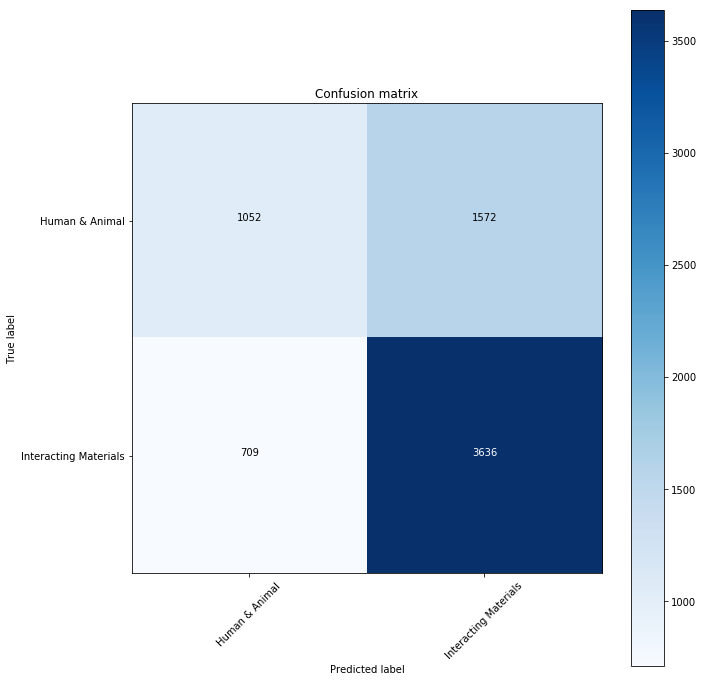

In [11]:
pred = grsrch.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [16]:
pred_prob = grsrch.predict_proba(test_X)

In [18]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for row, p, prob, Y in zip(test.iterrows(), pred, pred_prob, test_y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Actual target'].append(classes[int(row[1]['target'])])
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [19]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.625495,0.374505
Interacting Materials,0.303465,0.696535


In [20]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.595238,0.404762
breathing,0.304989,0.695011
brushing_teeth,0.595238,0.404762
can_opening,0.631746,0.368254
car_horn,0.614512,0.385488
cat,0.349490,0.650510
chainsaw,0.590062,0.409938
chirping_birds,0.276190,0.723810
church_bells,0.639610,0.360390


In [21]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.640096,0.359904
Interacting Materials,0.239785,0.760215


In [22]:
average_prob = correctly_classified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.274336,0.725664
breathing,0.626984,0.373016
brushing_teeth,0.185012,0.814988
can_opening,0.307143,0.692857
car_horn,0.270010,0.729990
cat,0.605442,0.394558
chainsaw,0.290947,0.709053
chirping_birds,0.612554,0.387446
church_bells,0.367880,0.632120


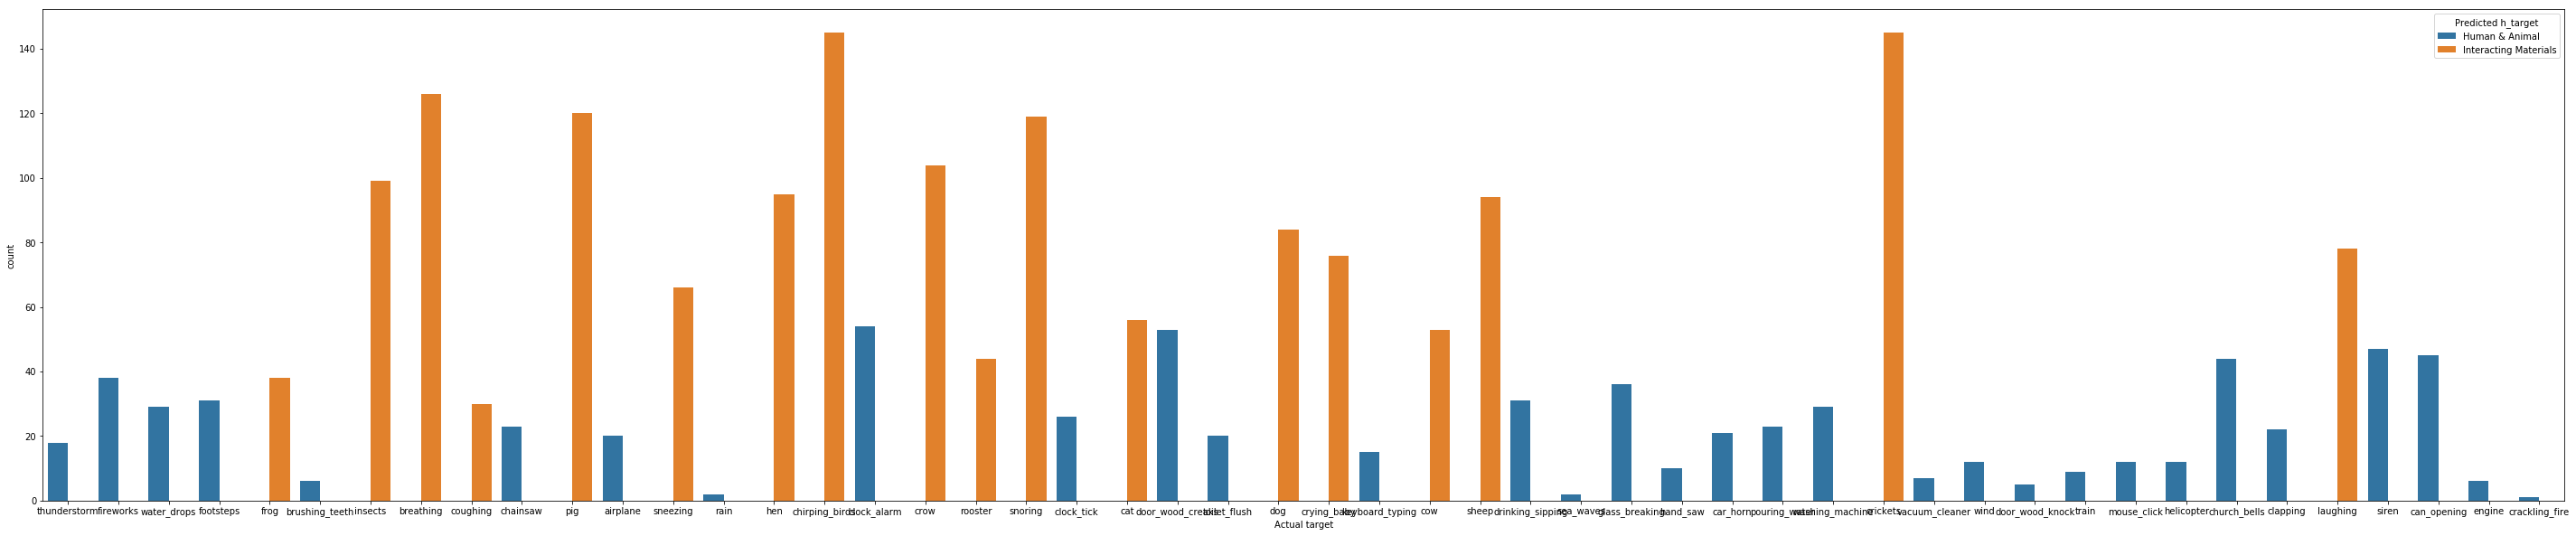

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)